In [12]:
%load_ext Cython
import numpy as np
import matplotlib.pyplot as plt

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [13]:
%%cython
import numpy as np  #import numpy inside Cython

#from libc.stdlib cimport rand, srand, RAND_MAX #rand() for linear values
cimport numpy as np
cimport cython
from libc.time cimport time
from libc.math cimport exp 
srand(time(NULL))

from mc_lib.rndm import RndmWrapper

from mc_lib.rndm cimport RndmWrapper

@cython.boundscheck(False)
@cython.wraparound(False) 
cdef np.ndarray initialstate(int linear_size, RndmWrapper rndm): 
    # initialalise lattice with 1, -1
    cdef np.ndarray[np.int_t,
                  ndim=2,
                  negative_indices=False,
                  mode='c'] lattice = \
                    np.zeros([linear_size, linear_size], dtype=int)
                    #np.random.choice([1, -1], size=(linear_size, linear_size))
    cdef int i
    cdef int j
    for i in range(0, linear_size):
        for j in range(0, linear_size):
                lattice[i,j] = 1 if rndm.uniform() > 0.5 else -1
    return lattice


@cython.boundscheck(False) 
@cython.wraparound(False)  
cdef np.ndarray mcmove(np.ndarray config,double beta,int L, RndmWrapper rndm):
    # config = lattice configuration on current step
    # beta = 1/temperature
    # L - size of lattice
    cdef:
        int i
        int j
        # Choose a random spin
        int a = int(rndm.uniform()*L)
        int b = int(rndm.uniform()*L)
        # current spin: sigma_i
        int s =  config[a, b]
        #  count neighbours: up, down, left, right
        #  nb = sum( sigma_j )
        int nb = config[(a+1)%L,b] + config[a,(b+1)%L] + \
               config[(a-1)%L,b] + config[a,(b-1)%L]
        # delta energy  = 2 * sigma_i * sum( sigma_j )
        double dE = 2*s*nb
        double ratio = exp(-dE*beta)
    if rndm.uniform() < ratio:
        s *= -1
    elif dE < 0:
        s *= -1
    config[a, b] = s
    return config


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire functio
cdef double calcEnergy(np.ndarray config, int L):
    # config = lattice configuration on current step
    # L - size of lattice
    cdef:
        int i
        int j
        int S
        int nb 
        double energy = 0
    # Energy = sum( -sigma_i * sum( sigma_j ))
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i,(j+1)%L] + \
                 config[(i-1)%L, j] + config[i,(j-1)%L]
            energy += -nb*S
    return energy/4.
    
#########################################################################
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def Isingv(linear_size,
                  steps,
                  relax,
                  T,
                  nt):
  # T - temperature range
  # nt - number of temperature points
    
    cdef RndmWrapper rndm = RndmWrapper((time(NULL), 0))
    
    cdef:
        np.ndarray[np.int_t, ndim=2, negative_indices=False,mode='c'] config
        double Ene
        double Mag
        double iT
        double iT2
        double E1
        double M1
        double E2
        double M2
        list E = []
        list M = []
        list C = []
        list X = []
        list energies = []
        list spins = []
        double n1 = 1.0/(steps*linear_size*linear_size)
        double n2 = n1 / steps
    for tt in range(nt):
        # for each temperature 
        dE1 = 0
        dM1 = 0
        dE2 = 0
        dM2 = 0
        energies = []
        spins = []
        # init lattice
        config = initialstate(linear_size, rndm)
        iT=1.0/T[tt] # inversed temperature
        iT2=iT*iT # squared temperature 
        print(iT)
    
        for i in range(relax):         # equilibrate
            mcmove(config, iT, linear_size, rndm)

        for i in range(steps):
            mcmove(config, iT, linear_size, rndm)           
            Ene = calcEnergy(config, linear_size)     # calculate the energy
            Mag = np.sum(config)        # calculate the magnetization
            energies.append(Ene)
            spins.append(Mag)
            dE1 = dE1 + Ene
            dM1 = dM1 + Mag
            dM2 = dM2 + Mag*Mag 
            dE2 = dE2 + Ene*Ene
        E.append(n1*dE1)
        M.append(n1*dM1)
        C.append((n1*dE2 - n2*dE1*dE1)*iT2)
        X.append((n1*dM2 - n2*dM1*dM1)*iT)
    return E, M, C, X, energies, spins

In [14]:
ntt = 32
T = np.linspace(1.0, 4.0, ntt)
print('get')
E, M, C, X, Enes, Spins = Isingv(linear_size = 10, steps = 10000,relax=5000, T=T, nt=ntt)

get
1.0
0.9117646813392639
0.837837815284729
0.7749999761581421
0.7209302186965942
0.6739130616188049
0.6326530575752258
0.5961538553237915
0.5636363625526428
0.5344827771186829
0.5081967115402222
0.484375
0.46268656849861145
0.44285714626312256
0.42465752363204956
0.40789473056793213
0.39240506291389465
0.37804877758026123
0.364705890417099
0.35227271914482117
0.34065935015678406
0.3297872245311737
0.3195876181125641
0.3100000023841858
0.3009708821773529
0.2924528419971466
0.2844036817550659
0.2767857015132904
0.269565224647522
0.26271185278892517
0.25619834661483765
0.25


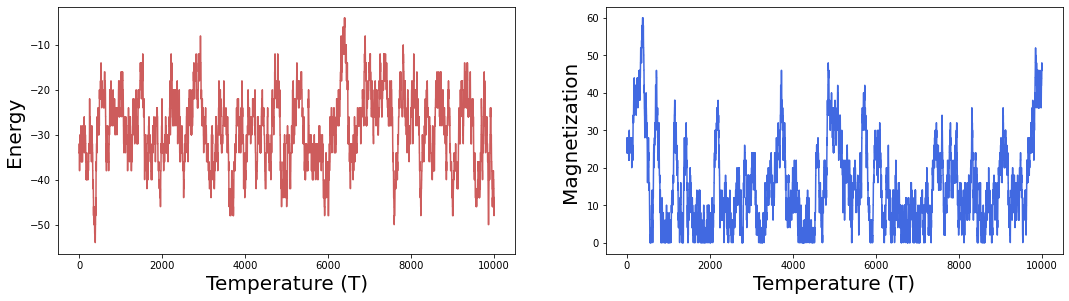

In [15]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(range(len(Enes)), Enes, color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(range(len(Spins)), np.abs(Spins), color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

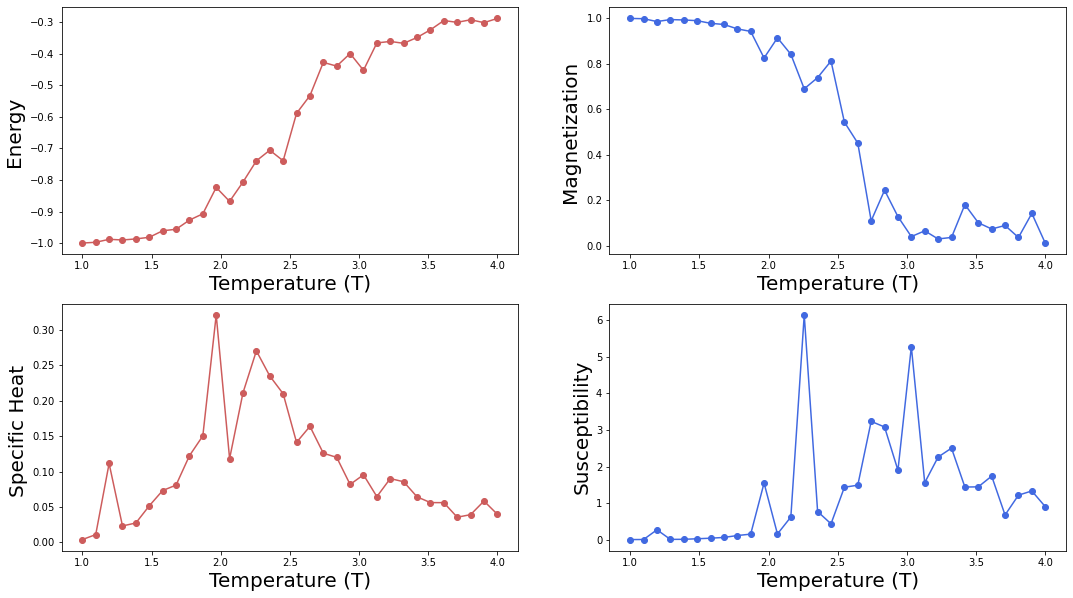

In [16]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, E,'o-', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, np.abs(M),'o-', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, C,'o-', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, X,'o-', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

In [17]:
ntt = 32
T = np.linspace(1.0, 4.0, ntt)
print('get')
E, M, C, X, Enes, Spins = Isingv(linear_size = 16, steps = 10000,relax=4000, T=T, nt=ntt)

get
1.0
0.9117646813392639
0.837837815284729
0.7749999761581421
0.7209302186965942
0.6739130616188049
0.6326530575752258
0.5961538553237915
0.5636363625526428
0.5344827771186829
0.5081967115402222
0.484375
0.46268656849861145
0.44285714626312256
0.42465752363204956
0.40789473056793213
0.39240506291389465
0.37804877758026123
0.364705890417099
0.35227271914482117
0.34065935015678406
0.3297872245311737
0.3195876181125641
0.3100000023841858
0.3009708821773529
0.2924528419971466
0.2844036817550659
0.2767857015132904
0.269565224647522
0.26271185278892517
0.25619834661483765
0.25


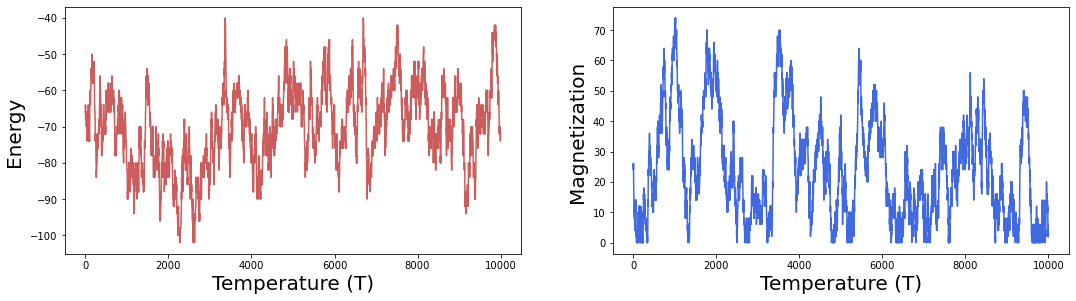

In [18]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(range(len(Enes)), Enes, color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(range(len(Spins)), np.abs(Spins), color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

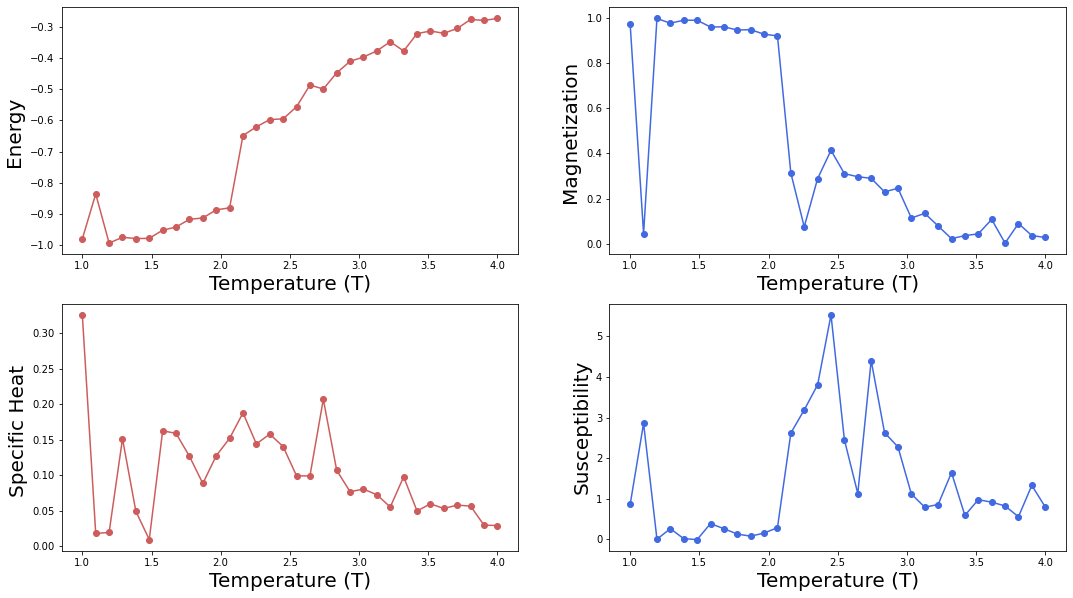

In [19]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, E,'o-', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, np.abs(M),'o-', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, C,'o-', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, X,'o-', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

In [20]:
ntt = 32
T = np.linspace(1.0, 4.0, ntt)
print('get')
E, M, C, X, Enes, Spins = Isingv(linear_size = 32, steps = 10000,relax=8000, T=T, nt=ntt)

get
1.0
0.9117646813392639
0.837837815284729
0.7749999761581421
0.7209302186965942
0.6739130616188049
0.6326530575752258
0.5961538553237915
0.5636363625526428
0.5344827771186829
0.5081967115402222
0.484375
0.46268656849861145
0.44285714626312256
0.42465752363204956
0.40789473056793213
0.39240506291389465
0.37804877758026123
0.364705890417099
0.35227271914482117
0.34065935015678406
0.3297872245311737
0.3195876181125641
0.3100000023841858
0.3009708821773529
0.2924528419971466
0.2844036817550659
0.2767857015132904
0.269565224647522
0.26271185278892517
0.25619834661483765
0.25


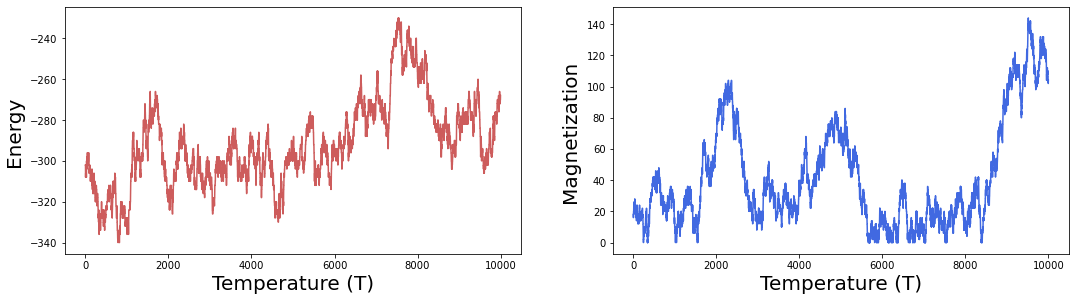

In [21]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(range(len(Enes)), Enes, color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(range(len(Spins)), np.abs(Spins), color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

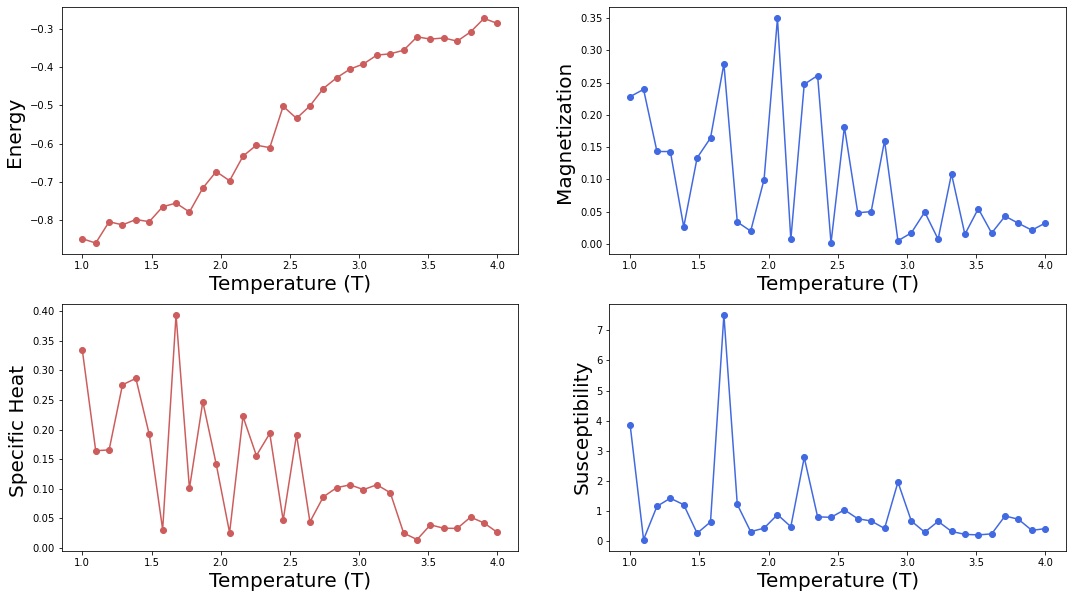

In [22]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.plot(T, E,'o-', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.plot(T, np.abs(M),'o-', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.plot(T, C,'o-', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.plot(T, X,'o-', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');